# Load Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import requests,io

import astroalign

from astropy.io import fits
from astropy.stats import median_absolute_deviation
from astropy.stats import sigma_clipped_stats,gaussian_sigma_to_fwhm
from astropy.table import QTable

from photutils.background import LocalBackground, MMMBackground
from photutils.detection import DAOStarFinder
from photutils.psf import IterativePSFPhotometry, IntegratedGaussianPRF



# Load the data of the night in question

In [2]:
data_path = '20230920/'

In [3]:


# Store images with labels
labeled_images = []

# Dictionaries to store types and filters
# Type : name of the object
unique_types = {}
# Filter : color of filter, filter == Black if no filter is used; if type == bias then filter = none 
unique_filters = {}

# Patern of file names
# All files expect for bias follow the pattern_flat
pattern_flat = r'(\w+)_(\d+-\d+-\d+)_(\d+-\d+-\d+)_(\w+)_(\d+).fits'
pattern_bias = r'bias_(\w+)_(\d+-\d+-\d+)_(\d+-\d+-\d+)_(\d+).fits'


for file in os.listdir(data_path):
    #print(file)
    match_flat = re.match(pattern_flat, file)
    match_bias = re.match(pattern_bias, file)

    if match_flat:
        type, date, time, filter, number = match_flat.groups()
    elif match_bias:
        type = 'bias'  
        _, date, time, number = match_bias.groups()
        filter = 'none' 

    # Store the image
    image = fits.open(name=data_path + file)
    image = image[0].data
    labeled_images.append((type, filter, number, image))

    # Update the dictionaries
    unique_types[type] = 1
    unique_filters[filter] = 1

# Print Dictionary
print("------ Dictionary ------")
print("Unique Types:", list(unique_types.keys()))
print("Unique Filters:", list(unique_filters.keys()))

# This is how to select a specific image, you have to specify the type, filter and number
#images = [image for type, filter, number, image in labeled_images if type == 'm29' and filter == 'Blue' and number == '0181']

# This is how to select more than one image, you have to specify the type and/or filter
#blue_flat_images = [image for type, filter, number, image in labeled_images if type == 'flat' and filter == 'Blue']


------ Dictionary ------
Unique Types: ['bias', 'deneb', 'Deneb', 'flat', 'hip100108', 'hip103833', 'M27', 'm29', 'polaris', 'vega']
Unique Filters: ['none', 'black', 'Blue', 'Green', 'Red']


# Reducing

In [ ]:
# Master Bias
bias_images = [(image) for type, filter, number, image in labeled_images if type == 'bias']

master_bias = np.median(np.asarray(bias_images), axis=0)

# Error assciated to master_bias
master_bias_error = median_absolute_deviation(np.asarray(bias_images), axis = 0)


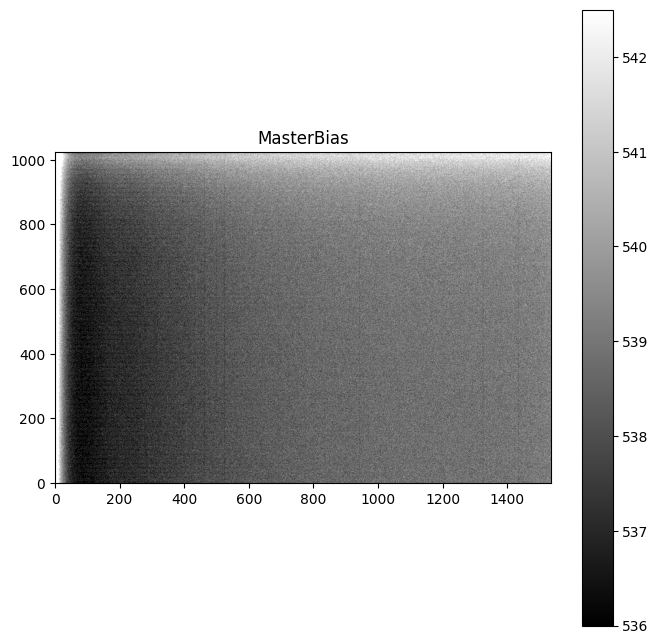

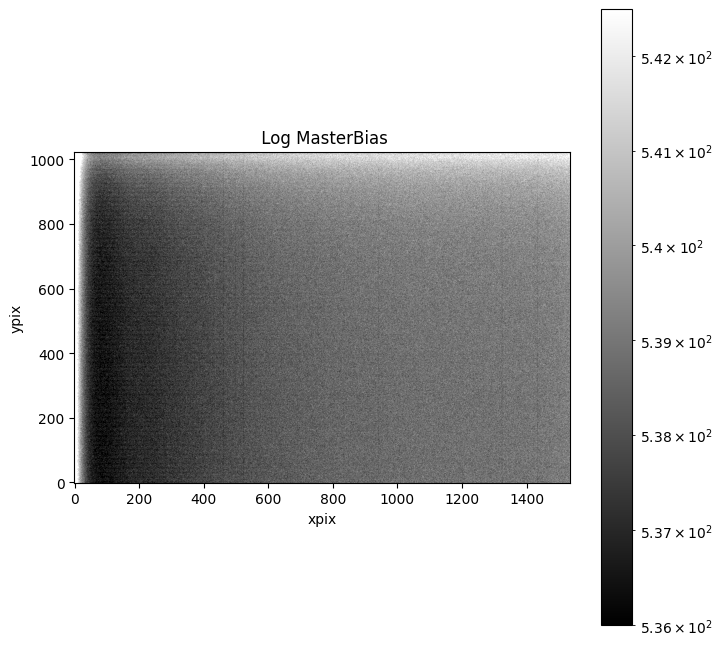

In [ ]:
lo,up= np.percentile(master_bias,1),np.percentile(master_bias,99)

plt.figure(figsize=(8, 8))
plt.imshow(master_bias, cmap='gray', origin='lower', clim=(lo,up))
plt.title(f"MasterBias")
plt.colorbar()
plt.show()


plt.figure(figsize=(8, 8))
plt.imshow(master_bias, cmap='gray', origin='lower', clim=(lo,up), norm='log')
plt.title(f" Log MasterBias")
plt.colorbar()
plt.xlabel('xpix')
plt.ylabel('ypix')
plt.show()

In [ ]:
# Initialize a dictionary to store master flats for each filter
master_flats = {}
master_flats_error = {}

for filter_label in unique_filters.keys():
 
    filter_flat_images_data = [(number, image) for type, filter, number, image in labeled_images if type == 'flat' and filter == filter_label]

    if not filter_flat_images_data:
        continue

    # Master flat for the current filter
    cflats = []
    cflats_error = []
    for image_number, image_data in filter_flat_images_data:
        cflats.append((image_data - master_bias) / np.median(image_data - master_bias)) # Professor said we don't need to propagate the error coming from / np.median(image_data - master_bias))
        cflats_error.append( master_bias_error/ np.median(image_data - master_bias) )
        
    
    master_flat = np.median(cflats, axis=0)
    master_flat_error = median_absolute_deviation(cflats, axis = 0) + median_absolute_deviation(np.median((cflats_error), axis = 0)) # Should I do the MAD of the error?

    # Store the master flat in the dictionary with the filter label as the key
    master_flats[filter_label] = master_flat
    master_flats_error[filter_label] = master_flat_error


In [ ]:
print(master_flats_error['Blue'])

print(master_flats['Blue'])

[[0.00192573 0.00442466 0.00308979 ... 0.00094949 0.00161874 0.00194639]
 [0.00319398 0.00371051 0.00216286 ... 0.00194815 0.00157761 0.00224121]
 [0.00270605 0.00063869 0.00211789 ... 0.00195347 0.00346317 0.00221717]
 ...
 [0.00149241 0.00246776 0.00439894 ... 0.00208586 0.00258747 0.00371855]
 [0.00355398 0.00350562 0.00178944 ... 0.00178684 0.00316782 0.00221981]
 [0.00132521 0.00316475 0.00119674 ... 0.00165519 0.00268859 0.0014864 ]]
[[1.06106091 1.0807592  1.06849217 ... 1.09225476 1.10941813 1.03470831]
 [1.0491079  1.05675073 1.04424457 ... 1.06589868 1.08583828 1.02740438]
 [1.03044008 1.03457931 1.02351465 ... 1.04308381 1.07028621 1.01443624]
 ...
 [1.02679283 1.03538682 1.01538432 ... 1.03089495 1.05480399 1.00451997]
 [1.03533215 1.03998771 1.01883773 ... 1.04422781 1.06442629 1.01998127]
 [1.01291419 1.00829151 0.9991986  ... 1.01325973 1.02898895 0.97291663]]


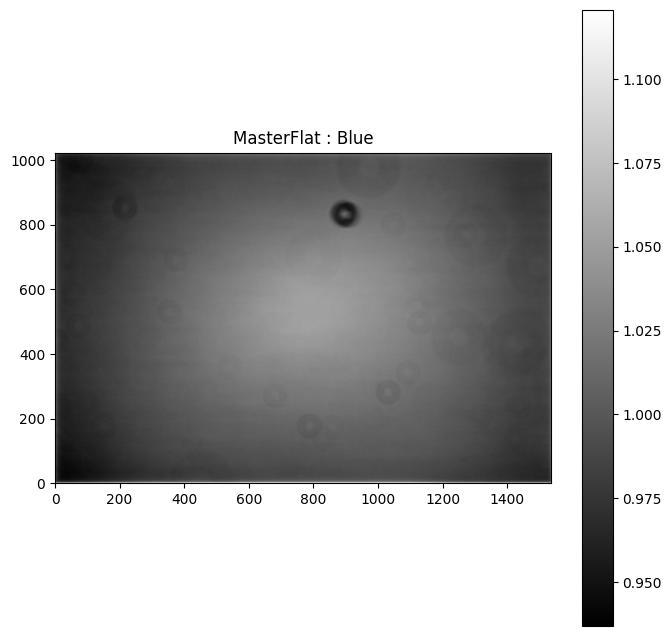

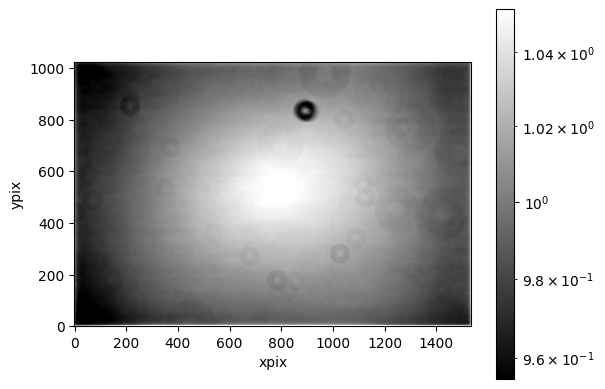

In [ ]:
# Master flat for blue Filter
plt.figure(figsize=(8, 8))
plt.imshow(master_flats['Blue'], cmap='gray', origin='lower')
plt.title(f"MasterFlat : Blue")
plt.colorbar()
plt.show()

lo,up= np.percentile(master_flats['Blue'],1),np.percentile(master_flats['Blue'],99)
plt.figure()
plt.imshow(master_flats['Blue'], cmap='gray', origin='lower', clim=(lo,up), norm='log')
plt.colorbar()
plt.xlabel('xpix')
plt.ylabel('ypix')
plt.show()

## Function that performs Image Reduction + Alignment

In [ ]:
# Performs Image Reduction before alignment
def align_images(type_label, filter_label, MIN = None, MAX = None, verbose = True):

    # Check if both MIN and MAX are not None
    if MIN is not None and MAX is not None:
        # Filter the labeled_images to include only those with 'number' in the range [MIN, MAX]
        flat = [(type, number, image) for type, filter, number, image in labeled_images if type == type_label and filter == filter_label and MIN <= int(number) <= MAX]

    else:
        flat = [(type, number, image) for type, filter, number, image in labeled_images if type == type_label and filter == filter_label]
    
    
    # Store the first flat as the reference flat and performs reduction
    current_reference_flat = (flat[0][2] - master_bias)/master_flats[filter_label]

    # Initialize a list to store reduced and aligned flats
    aligned_flats = []
    aligned_flats_error = []
    
    for type, number, image_data in flat:

        #Reduce Image before alignement
        reduced_img = (image_data - master_bias)/master_flats[filter_label]

        #reduced_img_error = (image_data - master_bias)/(master_flats[filter_label]**2)*master_flat_error[filter_label] + master_bias_error/(master_flat[filter_label])
        reduced_img_error = np.sqrt(  (((image_data - master_bias)/(master_flats[filter_label]**2)) * master_flats_error[filter_label])**2   +   (master_bias_error / master_flats[filter_label])**2   )

        aligned_flat, footprint = astroalign.register(reduced_img, current_reference_flat, detection_sigma=5, max_control_points=50) 

        transform , _= astroalign.find_transform(current_reference_flat, reduced_img, detection_sigma=5, max_control_points=50)

        reduced_img_error = astroalign.apply_transform(transform, reduced_img_error, reduced_img_error)

        #note to self: increase sigma(Factor of background std-dev above which is considered a detection) if the images alone aren't blurry but the stacking has trails
        #increasing the max_control_points(The maximum number of control point-sources to find the transformation.) increases computing time:/

        # Normalize the aligned flat by dividing it by its median
        #aligned_flat = aligned_flat / np.median(aligned_flat)
    
        # Append the reduced and aligned flat to the list
        aligned_flats.append(aligned_flat)
        aligned_flats_error.append(reduced_img_error)

        if verbose:
            print(f'Object: {type} Image nr: {number} is aligned')
    
    if verbose:
        print("Done reduce and align :)")

    return aligned_flats, aligned_flats_error

### M29 BLUE[B]

Wednesday 20th September: M29 Blue[B] 
science 181-189

In [ ]:
#M29 Blue Filter
m29B_aligned, m29B_aligned_error  = align_images('m29', 'Blue', MIN=181, MAX=189)

Object: m29 Image nr: 0183 is aligned
Object: m29 Image nr: 0187 is aligned
Object: m29 Image nr: 0186 is aligned
Object: m29 Image nr: 0181 is aligned
Object: m29 Image nr: 0188 is aligned
Object: m29 Image nr: 0189 is aligned
Object: m29 Image nr: 0185 is aligned
Object: m29 Image nr: 0184 is aligned
Object: m29 Image nr: 0182 is aligned
Done reduce and align :)


In [ ]:
Error = m29B_aligned_error[1]/ m29B_aligned[1]
Error

array([[0.05797379, 0.06963639, 0.0663554 , ..., 0.06002814, 0.04729305,
        0.06971732],
       [0.08017427, 0.06174263, 0.05635586, ..., 0.04923943, 0.05435421,
        0.06384741],
       [0.0797143 , 0.06213465, 0.07270522, ..., 0.06288071, 0.04909732,
        0.0646542 ],
       ...,
       [0.07246376, 0.06350953, 0.06464082, ..., 0.05092177, 0.04975525,
        0.0523464 ],
       [0.06984005, 0.05684325, 0.06437145, ..., 0.06280055, 0.04935502,
        0.05146078],
       [0.09063885, 0.06508181, 0.05250149, ..., 0.06472292, 0.05103177,
        0.06739811]])

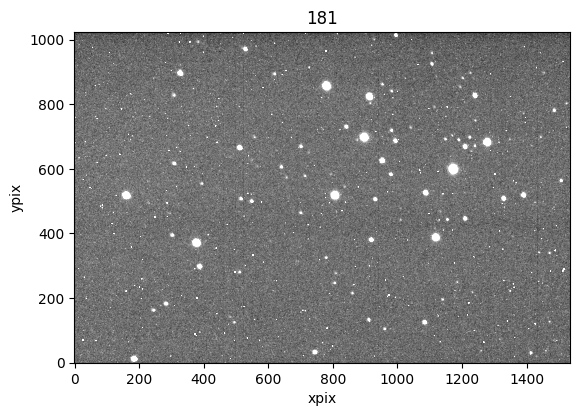

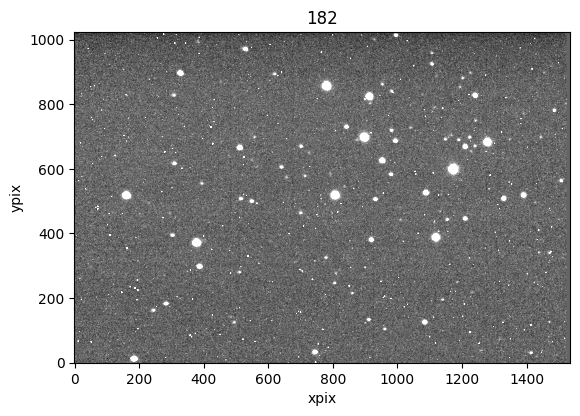

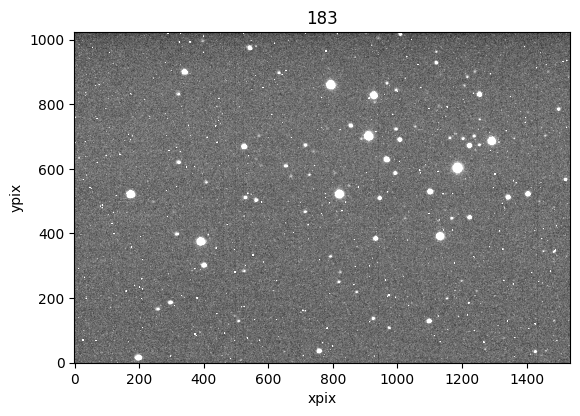

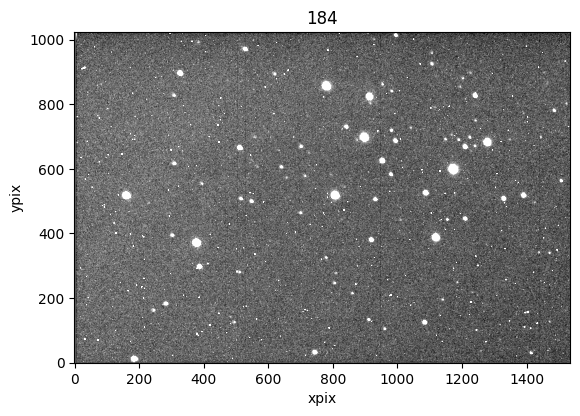

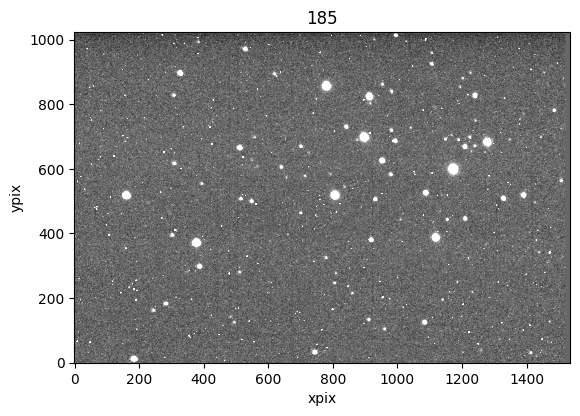

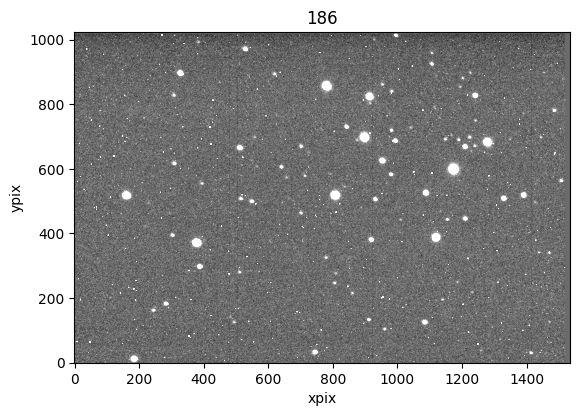

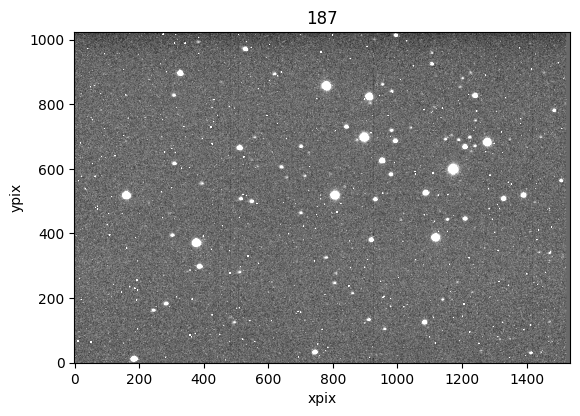

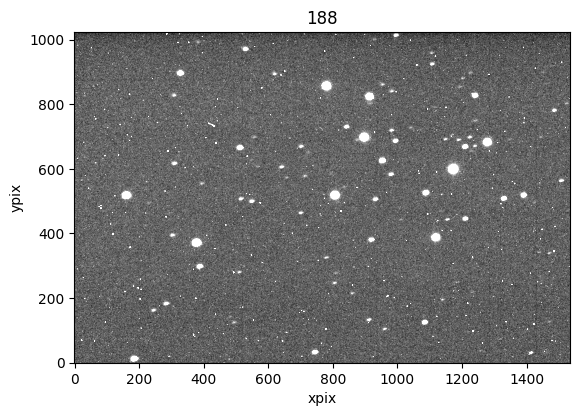

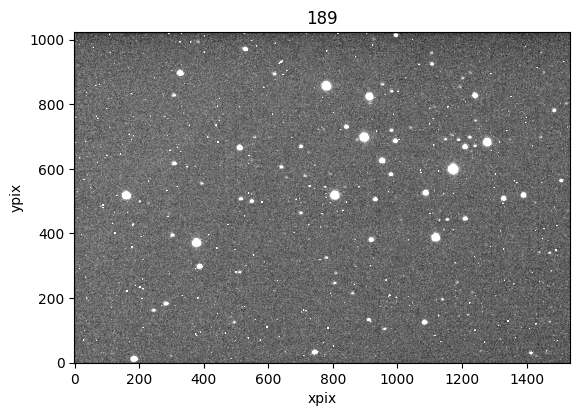

In [ ]:
# check if blurred
for i,image_data in enumerate(m29B_aligned):
    lo,up= np.percentile(image_data,1),np.percentile(image_data,99)
    plt.figure()
    plt.title(i+181)
    plt.imshow(image_data, cmap='gray', origin='lower', clim=(lo,up))
    plt.xlabel('xpix')
    plt.ylabel('ypix')
    plt.show()


[[0.1448419  0.07018114 0.09141732 ... 0.0373865  0.03605394 0.0366087 ]
 [0.05958603 0.08164519 0.12042399 ... 0.0373865  0.03821125 0.0366087 ]
 [0.1459292  0.08086011 0.0714733  ... 0.0373865  0.03650865 0.0366087 ]
 ...
 [0.0490046  0.04103923 0.04521979 ... 0.0373865  0.0373865  0.03737061]
 [0.04460968 0.03675736 0.03370239 ... 0.03603927 0.03821125 0.03675736]
 [0.03890309 0.03948075 0.0373865  ... 0.03661214 0.0366087  0.03821125]]


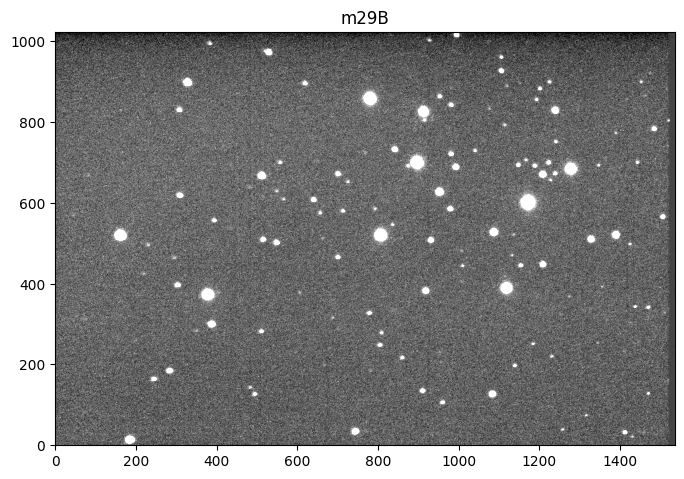

In [ ]:
# since they seem fine...
# Stack images
m29B = np.median(np.stack(m29B_aligned, axis=0), axis=0)

m29B_stack_error = np.sqrt((median_absolute_deviation(np.median((m29B_aligned_error), axis = 0)))**2 + (median_absolute_deviation(np.stack(m29B_aligned, axis=0), axis = 0))**2)
print(m29B_stack_error/m29B) 

lo,up= np.percentile(m29B,1),np.percentile(m29B,99)

plt.figure(figsize=(8, 8))
plt.imshow(m29B, cmap='gray', origin='lower', clim=(lo,up))
plt.title(f"m29B")
plt.show()


## M29 GREEN[V]

Wednesday 20th September: M29 Blue[B] 
science 169-178

In [ ]:
#M29 Green Filter
m29G_aligned, m29G_aligned_error  = align_images('m29', 'Green', MIN=169, MAX=178)


Object: m29 Image nr: 0172 is aligned
Object: m29 Image nr: 0176 is aligned
Object: m29 Image nr: 0177 is aligned
Object: m29 Image nr: 0170 is aligned
Object: m29 Image nr: 0171 is aligned
Object: m29 Image nr: 0173 is aligned
Object: m29 Image nr: 0178 is aligned
Object: m29 Image nr: 0174 is aligned
Object: m29 Image nr: 0175 is aligned
Object: m29 Image nr: 0169 is aligned
Done reduce and align :)


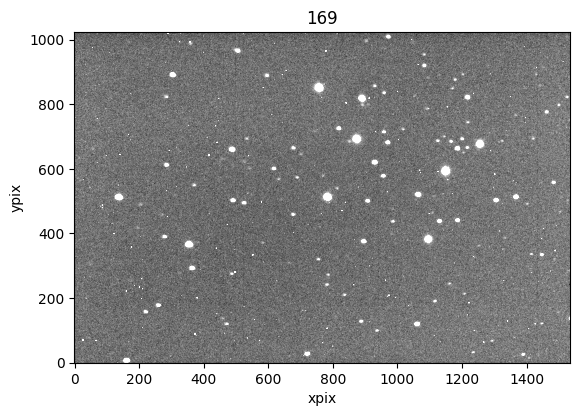

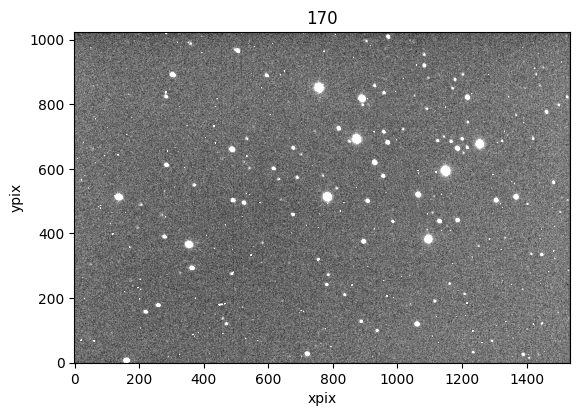

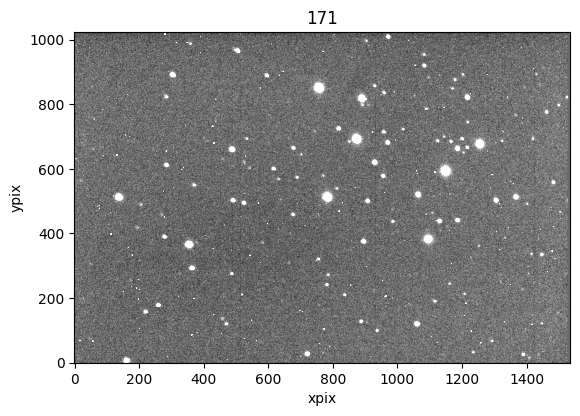

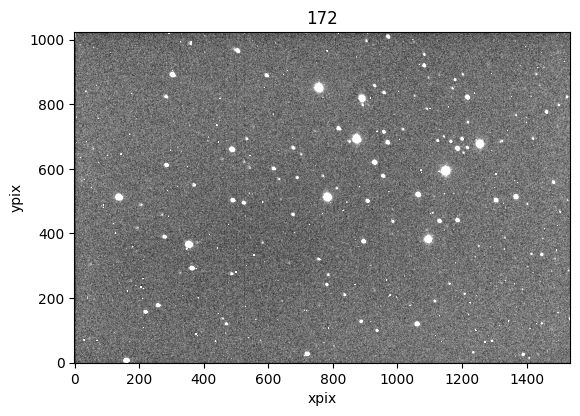

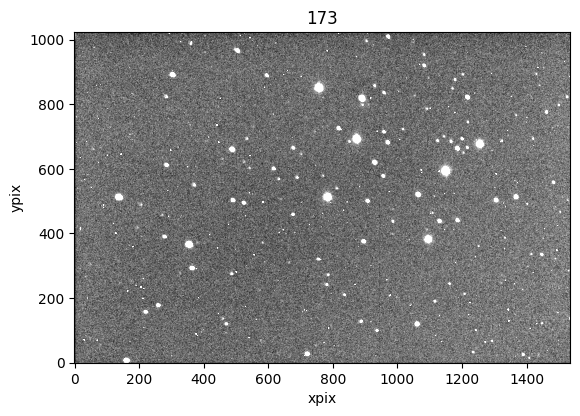

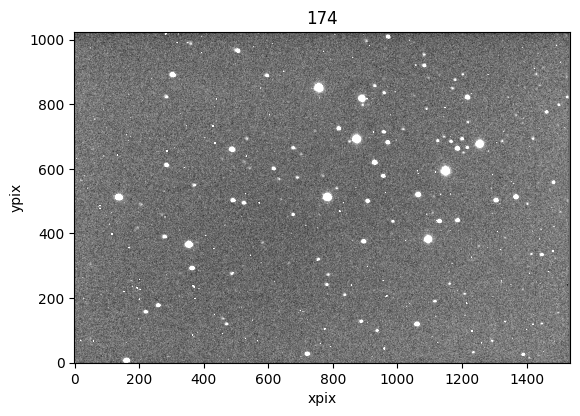

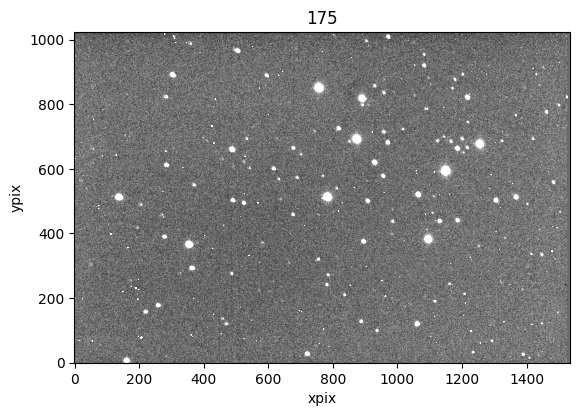

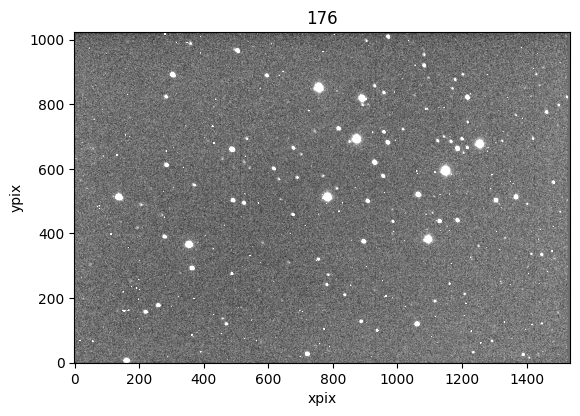

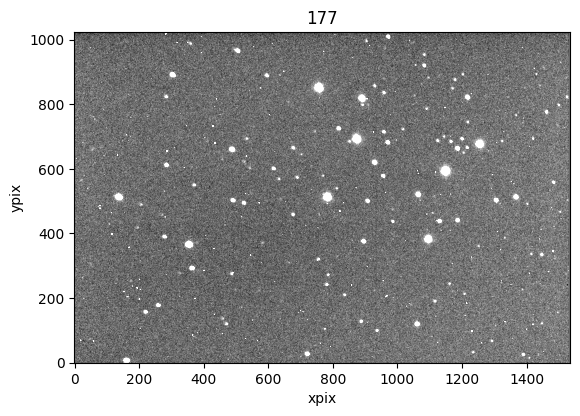

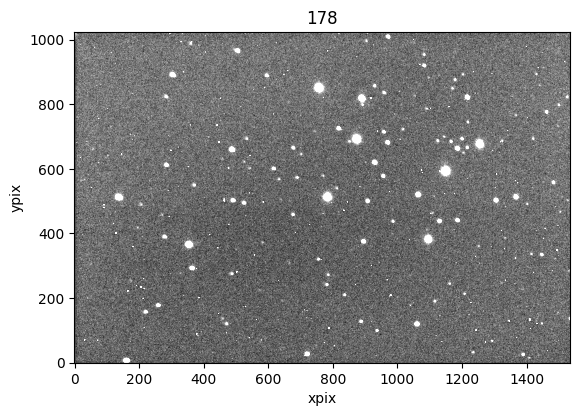

In [ ]:
# check if blurred

for i,image_data in enumerate(m29G_aligned):
    lo,up= np.percentile(image_data,1),np.percentile(image_data,99)
    plt.figure()
    plt.title(i+169)
    plt.imshow(image_data, cmap='gray', origin='lower', clim=(lo,up))
    plt.xlabel('xpix')
    plt.ylabel('ypix')
    plt.show()

[[0.03124706 0.02532475 0.02529423 ... 0.02779139 0.02884181 0.01898399]
 [0.0147582  0.02966043 0.0337937  ... 0.02065804 0.02619256 0.03161676]
 [0.02895362 0.02734509 0.03208726 ... 0.02362743 0.02533984 0.02059063]
 ...
 [0.03520291 0.06583147 0.03484396 ... 0.01743317 0.02104557 0.01775781]
 [0.02319048 0.02925823 0.02856969 ... 0.01512391 0.02147044 0.02492351]
 [0.02237234 0.01821538 0.02451088 ... 0.02422724 0.02619256 0.02520112]]


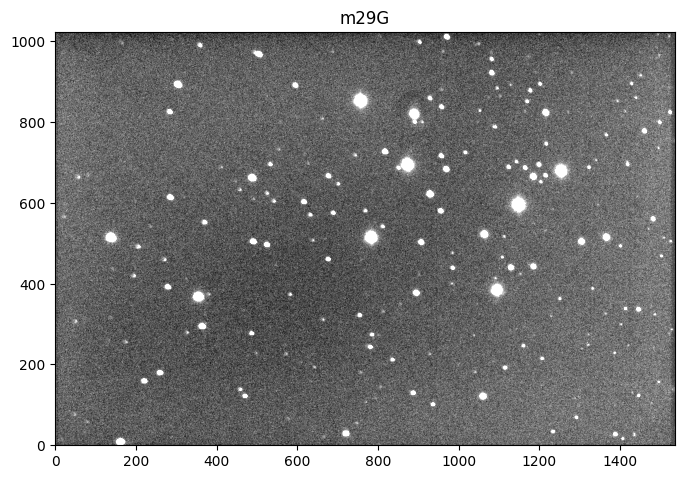

In [ ]:

# since they seem fine...
# Stack images
m29G = np.median(np.stack(m29G_aligned, axis=0), axis=0)


m29G_stack_error = np.sqrt((median_absolute_deviation(np.median((m29G_aligned_error), axis = 0)))**2 + (median_absolute_deviation(np.stack(m29G_aligned, axis=0), axis = 0))**2)
print(m29G_stack_error/m29G) 

lo,up= np.percentile(m29G,1),np.percentile(m29G,99)

plt.figure(figsize=(8, 8))
plt.imshow(m29G, cmap='gray', origin='lower', clim=(lo,up))
plt.title(f"m29G")
plt.show()

# Saving Good Data

In [ ]:
save_path = 'reduced'

np.save(f'{save_path}/M29B.npy', m29B)
np.save(f'{save_path}/M29G.npy', m29G)


In [ ]:
# Align Blue and Green Filter Images

transform, _ = astroalign.find_transform(m29B, m29G, detection_sigma=5, max_control_points=50)
m29G, _ = astroalign.apply_transform(transform, m29G, m29G)
m29G_stack_error, _ = astroalign.apply_transform(transform, m29G_stack_error, m29G_stack_error)

In [ ]:
np.save(f'{save_path}/M29G.npy', m29G)
np.save(f'{save_path}/M29B.npy', m29B)
np.save(f'{save_path}/M29G_error.npy', m29G_stack_error)
np.save(f'{save_path}/M29B_error.npy', m29B_stack_error)